## Processing

In [65]:
# Install bcftools
!apt-get install -y bcftools

# Install cyvcf2 and its dependencies
!pip install cyvcf2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libhts3 libhtscodecs2
Suggested packages:
  python3-numpy python3-matplotlib texlive-latex-recommended
The following NEW packages will be installed:
  bcftools libhts3 libhtscodecs2
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,140 kB of archives.
After this operation, 3,448 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhtscodecs2 amd64 1.1.1-3 [53.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhts3 amd64 1.13+ds-2build1 [390 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bcftools amd64 1.13-1 [697 kB]
Fetched 1,140 kB in 2s (557 kB/s)
Selecting previously unselected package libhtscodecs2:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libhtscodecs2_1.1.

In [ ]:
import pandas as pd

# Load T2D SNPs file
gwas_df = pd.read_csv("t2d_snp.txt", sep=r"\s+", engine="python")

# Clean column names (strip leading/trailing spaces)
gwas_df.columns = gwas_df.columns.str.strip()

# Sort by p-value (most significant first)
df_sorted = gwas_df.sort_values(by="P_VALUE")

# Take top 100,000
df_top100k = df_sorted.head(100000)


In [ ]:
df_top100k.to_csv("t2d_snp_top100k.txt", sep="\t", index=False)

In [ ]:
with open("t2d_snps.bed", "w") as f:
    for _, row in df_top100k.iterrows():
        chrom = str(row['CHROMOSOME']).strip()
        pos = int(row['POSITION'])
        rsid = row['SNP'].strip()
        # BED is 0-based, half-open
        f.write(f"chr{chrom}\t{pos}\t{pos+1}\t{rsid}\n")

In [ ]:
!awk -v OFS='\t' '{mid=int(($2+$3)/2); print $1, mid-50, mid+51, $4}' t2d_snps.bed > t2d_snp_expanded.bed

In [ ]:
!sed 's/^chr//' t2d_snp_expanded.bed > t2d_snps_nochr_expanded.bed

In [66]:
!apt-get install -y bedtools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 563 kB of archives.
After this operation, 1,548 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 bedtools amd64 2.30.0+dfsg-2ubuntu0.1 [563 kB]
Fetched 563 kB in 1s (391 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 126176 files and directories currently installed.)
Preparing to unpack .../bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Setting up bedtools (2.30.0+dfsg-2ubuntu0.1) ...


In [ ]:
!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg18/bigZips/hg18.fa.gz

# Unzip
!gunzip hg18.fa.gz

--2025-05-14 23:16:15--  http://hgdownload.cse.ucsc.edu/goldenPath/hg18/bigZips/hg18.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 943409326 (900M) [application/x-gzip]
Saving to: ‘hg18.fa.gz’

hg18.fa.gz          100%[===================>] 899.71M  88.5MB/s    in 9.9s    

2025-05-14 23:16:25 (90.7 MB/s) - ‘hg18.fa.gz’ saved [943409326/943409326]



In [ ]:
!apt-get update
!apt-get install -y samtools

!samtools faidx hg18.fa

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,930 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,721 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease 

In [ ]:
!bedtools getfasta -fi hg18.fa -bed t2d_snp_expanded.bed -fo snps_contexts_101bp.fa

Feature (chr6:170928800-170928901) beyond the length of chr6 size (170899992 bp).  Skipping.


In [ ]:
!pip install biopython
from Bio import SeqIO
def write_fasta_no_wrap(records, out_path):
    with open(out_path, "w") as out_f:
        for record in records:
            out_f.write(f">{record.id}\n{str(record.seq)}\n")
records = []
for record in SeqIO.parse("snps_contexts_101bp.fa", "fasta"):
    record.seq = record.seq.upper()
    records.append(record)

write_fasta_no_wrap(records, "snps_contexts_101bp_upper.fa")


In [ ]:
import gzip
import os
from Bio.SeqRecord import SeqRecord

#Load the risk alleles
df = pd.read_csv("t2d_snp_top100k.txt", sep="\t")
print(f"Loaded {len(df)} SNPs from t2d_snp_y=top100k.txt")

# Build SNP to risk allele dictionary
snp_risk_dict = {
    f"chr{row['CHROMOSOME']}:{row['POSITION']}": row['RISK_ALLELE']
    for _, row in df.iterrows()
    if row['RISK_ALLELE'] in "ACGT"
}

#Load reference FASTA and create alternate sequences
input_fasta = "snps_contexts_101bp_upper.fa"
output_fasta = "snps_contexts_alt_101bp.fa"
snp_index = 50

records = []

for record in SeqIO.parse(input_fasta, "fasta"):
    header = record.id
    seq = str(record.seq)
    chrom, coords = header.split(":")
    start, _ = map(int, coords.split("-"))
    snp_pos = start + snp_index  # 1-based position
    key = f"{chrom}:{snp_pos}"

    alt = snp_risk_dict.get(key)
    if alt:
        new_seq = seq[:snp_index] + alt + seq[snp_index+1:]
        new_record = SeqRecord(
            seq=new_seq,
            id=header + f"|ALT={alt}",
            description=""
        )
        records.append(new_record)
        print(f"Replaced SNP at {key} with risk allele {alt}")
    else:
        print(f"No risk allele found for {key}, skipping")

#Write to output FASTA

write_fasta_no_wrap(records, output_fasta)
print(f"\n Saved {len(records)} SNP-altered sequences to {output_fasta}")

Loaded 100000 SNPs from t2d_snp_y=top100k.txt


/usr/local/lib/python3.11/dist-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Replaced SNP at chr10:57766812 with risk allele T
Replaced SNP at chr14:79516207 with risk allele C
Replaced SNP at chr10:57729570 with risk allele T
Replaced SNP at chr1:93374782 with risk allele C
Replaced SNP at chr10:17046561 with risk allele A
Replaced SNP at chr10:17047408 with risk allele G
Replaced SNP at chr2:195454401 with risk allele G
Replaced SNP at chr11:108161293 with risk allele G
Replaced SNP at chr6:105272575 with risk allele C
Replaced SNP at chr6:81107964 with risk allele A
Replaced SNP at chr12:100569429 with risk allele T
Replaced SNP at chr6:105271306 with risk allele T
Replaced SNP at chr2:156732343 with risk allele G
Replaced SNP at chr2:156709263 with risk allele A
Replaced SNP at chr8:128085365 with risk allele G
Replaced SNP at chr14:36015673 with risk allele A
Replaced SNP at chr18:64395160 with risk allele G
Replaced SNP at chr11:17352336 with risk allele T
Replaced SNP at chr11:21900199 with risk allele T

## Alternate Attention

In [ ]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [1]:
!git clone https://huggingface.co/jaandoui/DNABERT2-AttentionExtracted

Cloning into 'DNABERT2-AttentionExtracted'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 152 (delta 87), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (152/152), 119.16 KiB | 1.40 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [2]:
with open("DNABERT2-AttentionExtracted/flash_attn_triton.py", "w") as f:
    f.write("""
# Patched to disable FlashAttention
flash_attn_qkvpacked_func = None
""")

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("DNABERT2-AttentionExtracted", trust_remote_code=True)
model = AutoModel.from_pretrained("DNABERT2-AttentionExtracted", trust_remote_code=True, output_attentions = True).to(device)

/root/.cache/huggingface/modules/transformers_modules/DNABERT2-AttentionExtracted/bert_layers.py:128: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at DNABERT2-AttentionExtracted and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
!pip install biopython
from Bio import SeqIO

fasta_path = "snps_contexts_alt_101bp.fa"
records = list(SeqIO.parse(fasta_path, "fasta"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.8 MB/s eta 0:00:00


In [5]:
seq_ids = [rec.id for rec in records]
sequences = [str(rec.seq).upper() for rec in records]

batch_size = 32
attention_results = []
save_every = 1000
processed = 0

def batch_tokenize(seqs):
    return tokenizer(seqs, return_tensors="pt", padding=True, truncation=True)

for i in range(0, len(sequences), batch_size):
    batch_seqs = sequences[i:i+batch_size]
    batch_ids = seq_ids[i:i+batch_size]

    inputs = batch_tokenize(batch_seqs)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, return_dict=True, output_attentions=True)

    attentions = outputs[3]
    last_layer_attention = attentions[-1]

    for j, seq_id in enumerate(batch_ids):
        attention_results.append({
            "id": seq_id,
            "sequence": batch_seqs[j],
            "attention": last_layer_attention[j].cpu()
        })

    processed += len(batch_seqs)

    if processed % save_every == 0:
        torch.save(attention_results, f'attention_results_upto_{processed}.pt')
        print(f'Saved attention results for {processed} sequences.')

# Save final results
torch.save(attention_results, 'attention_results_final.pt')
print('Saved final attention results.')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Saved attention results for 4000 sequences.
Saved attention results for 8000 sequences.
Saved attention results for 12000 sequences.
Saved attention results for 16000 sequences.
Saved attention results for 20000 sequences.
Saved attention results for 24000 sequences.
Saved attention results for 28000 sequences.
Saved attention results for 32000 sequences.
Saved attention results for 36000 sequences.
Saved attention results for 40000 sequences.
Saved attention results for 44000 sequences.
Saved attention results for 48000 sequences.
Saved attention results for 52000 sequences.
Saved attention results for 56000 sequences.
Saved attention results for 60000 sequences.
Saved attention results for 64000 sequences.
Saved attention results for 68000 sequences.
Saved attention results for 72000 sequences.
Saved attention results for 76000 sequences.
Saved attention results for 80000 sequences.
Saved attention results for 84000 sequences.
Saved attention results for 88000 sequences.
Saved attent

In [14]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

attention_results_upto_60000 = torch.load('attention_results_upto_60000.pt')

max_len = max(att["attention"].shape[-1] for att in attention_results_upto_60000)

max_length = 26

def pad_attention(att):
    pad_amt = max_length - att.shape[-1]
    return F.pad(att, (0, pad_amt, 0, pad_amt))


all_attn = torch.stack([pad_attention(x["attention"]) for x in attention_results_upto_60000])

# Average over sequences
avg_attn = all_attn.mean(dim=0)

snp_token_index = 10


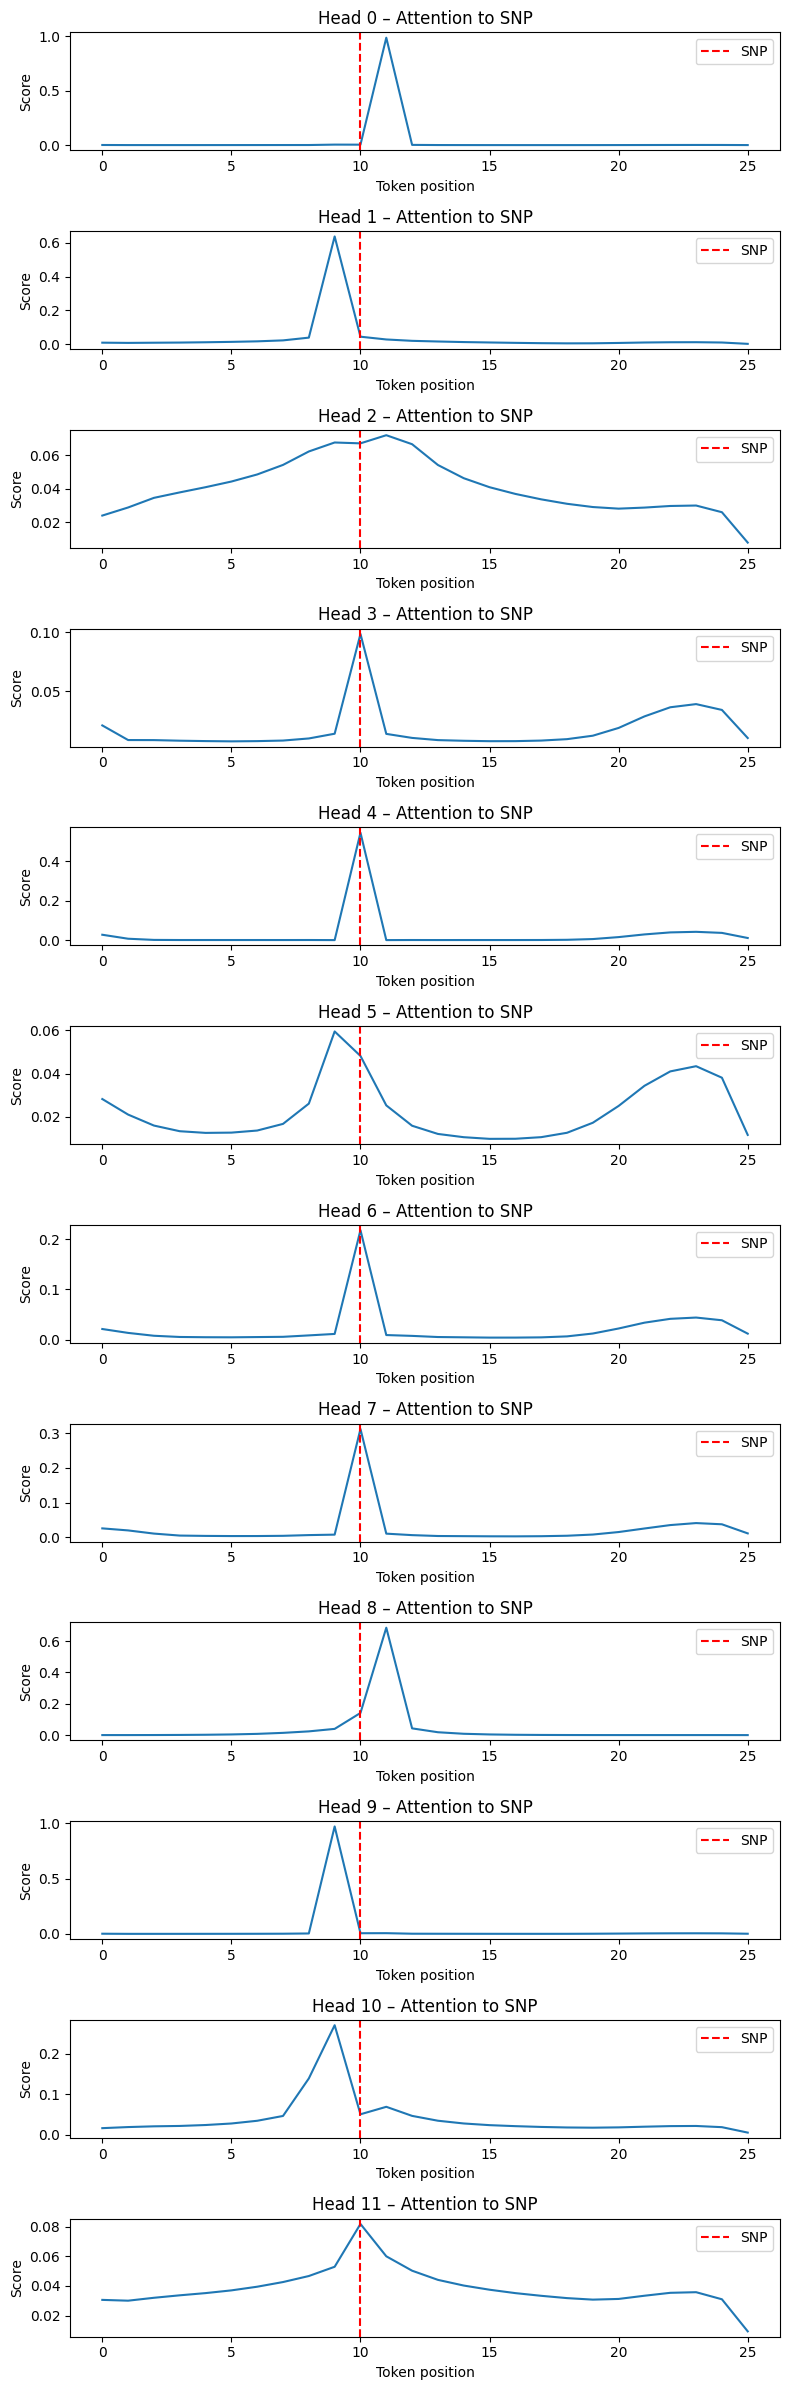

In [15]:
# Attention TO the SNP position (column)
attn_to_snp = avg_attn[:, :, snp_token_index]

# Attention FROM the SNP position (row)
attn_from_snp = avg_attn[:, snp_token_index, :]

num_heads = avg_attn.shape[0]
fig, axs = plt.subplots(nrows=num_heads, figsize=(8, 2 * num_heads))

for i in range(num_heads):
    axs[i].plot(attn_to_snp[i].cpu().numpy())
    axs[i].set_title(f"Head {i} – Attention to SNP")
    axs[i].set_ylabel("Score")
    axs[i].set_xlabel("Token position")
    axs[i].axvline(snp_token_index, color='r', linestyle='--', label="SNP")
    axs[i].legend()

plt.tight_layout()
plt.show()

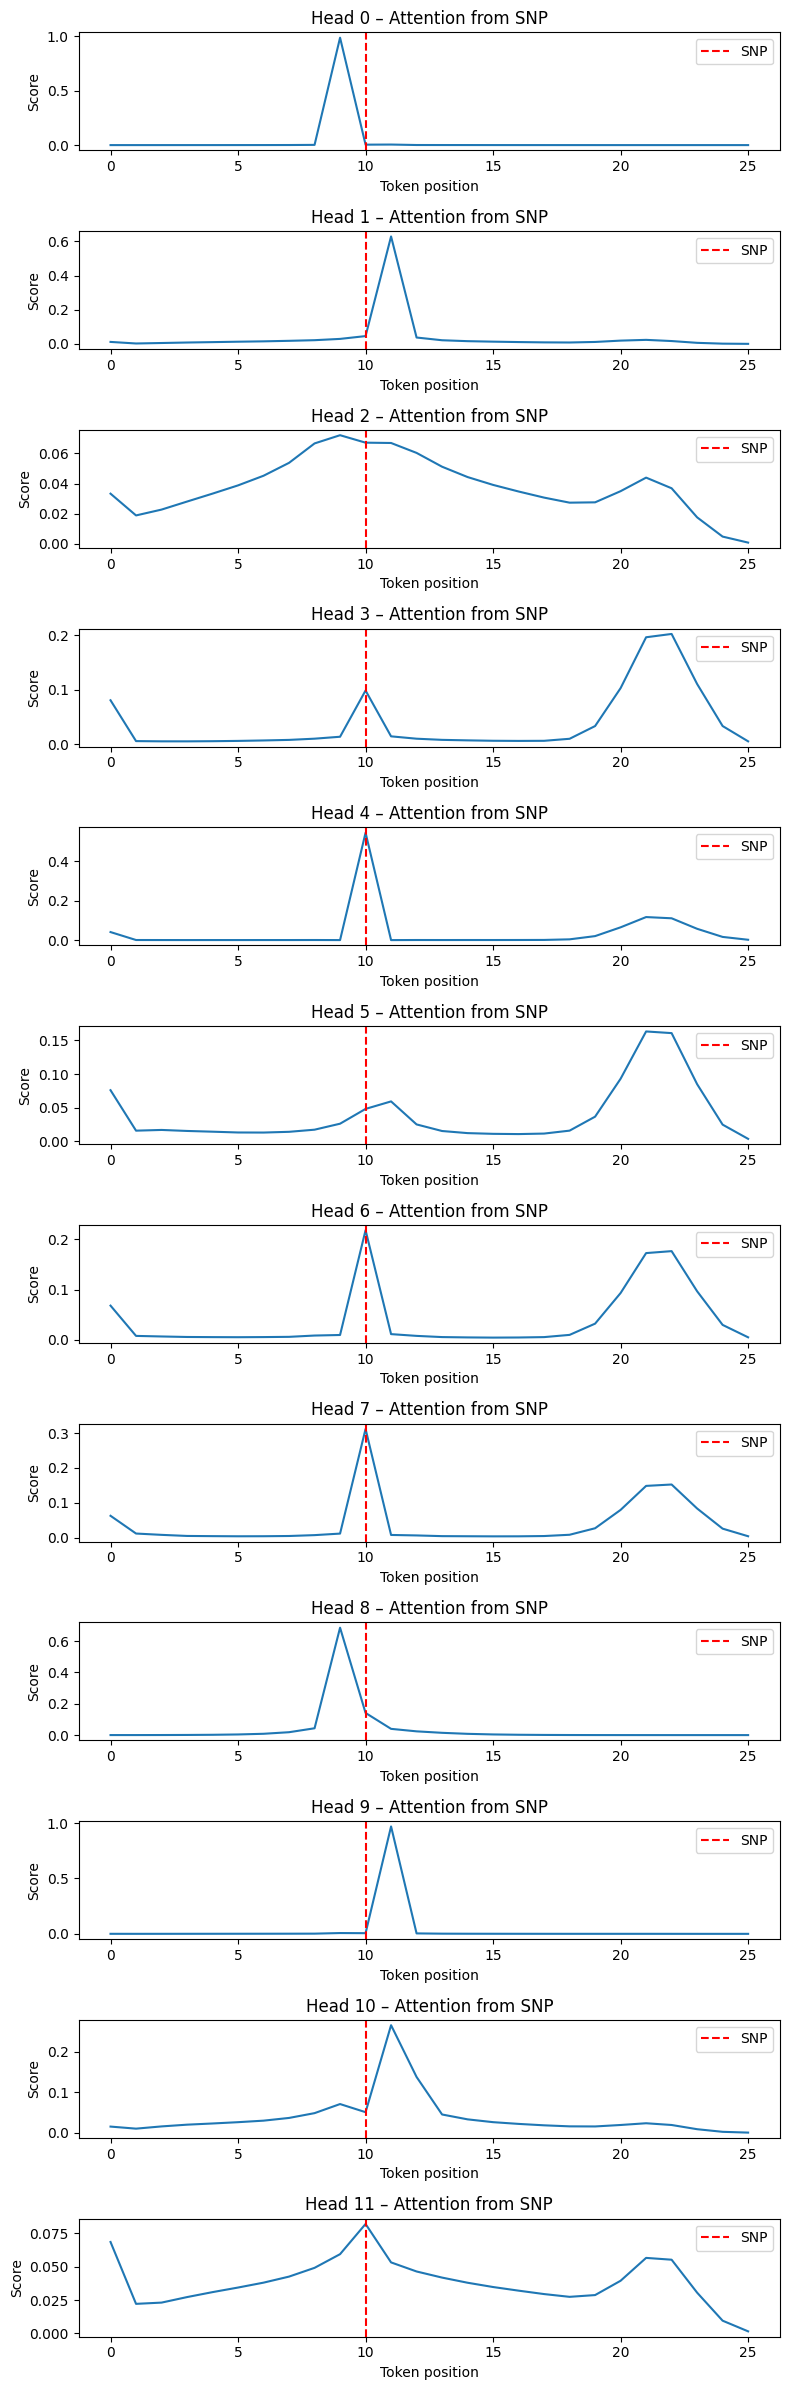

In [36]:
fig, axs = plt.subplots(nrows=num_heads, figsize=(8, 2 * num_heads))

for i in range(num_heads):
    axs[i].plot(attn_from_snp[i].cpu().numpy())
    axs[i].set_title(f"Head {i} – Attention from SNP")
    axs[i].set_ylabel("Score")
    axs[i].set_xlabel("Token position")
    axs[i].axvline(snp_token_index, color='r', linestyle='--', label="SNP")
    axs[i].legend()

plt.tight_layout()
plt.show()

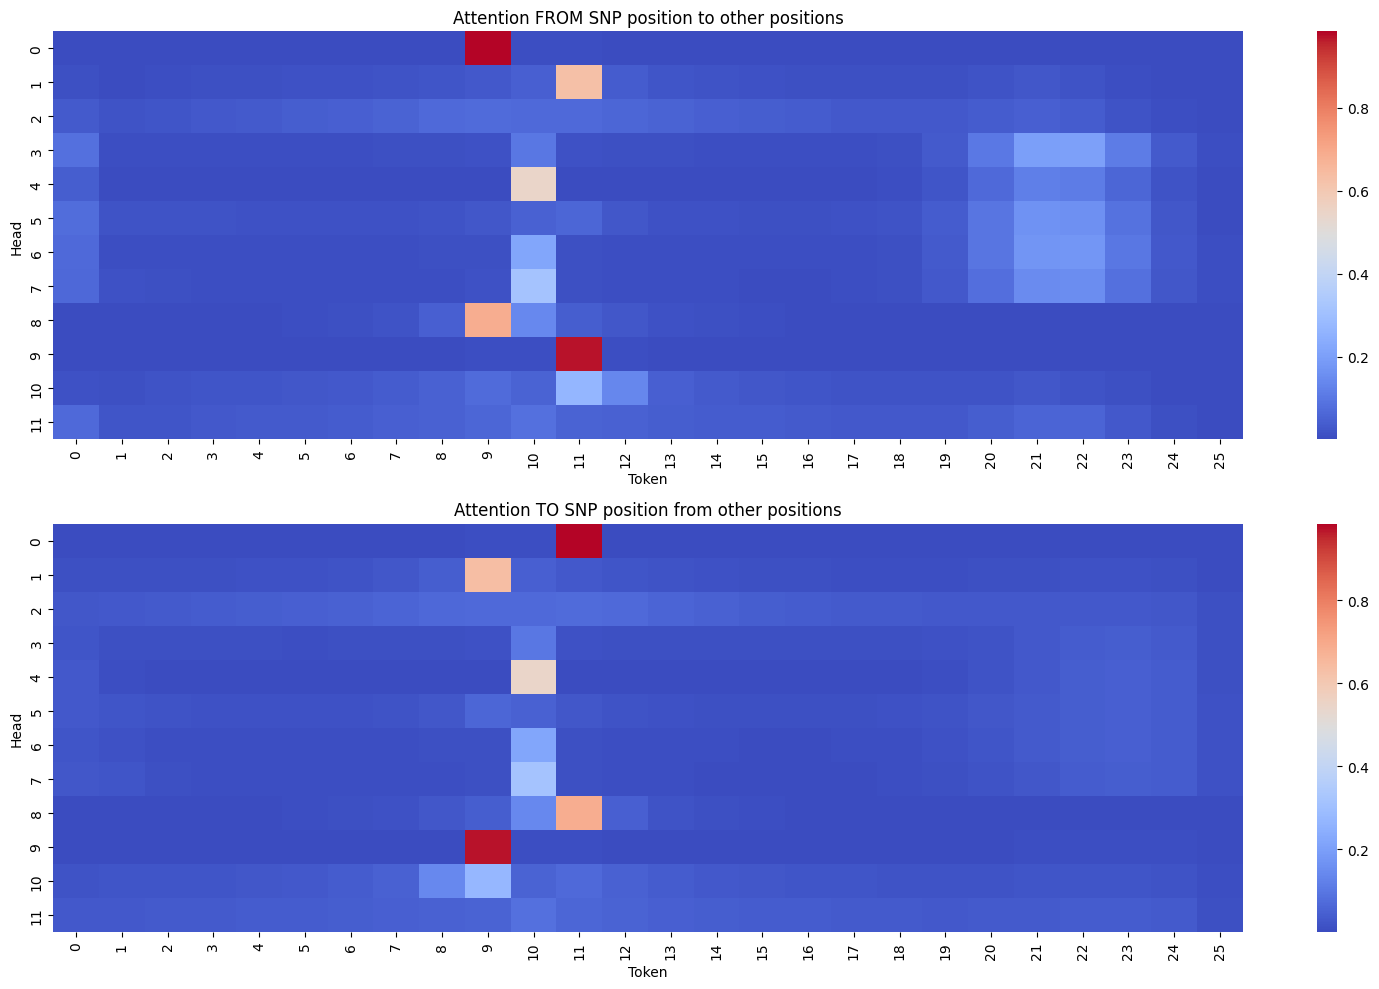

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

attn_from_snp = all_attn[:, :, snp_token_index, :]
attn_to_snp = all_attn[:, :, :, snp_token_index]
mean_from_snp = attn_from_snp.mean(dim=0)
mean_to_snp = attn_to_snp.mean(dim=0)


max_length = 26

mean_from_snp_np = mean_from_snp[:, :max_length].cpu().numpy()
mean_to_snp_np = mean_to_snp[:, :max_length].cpu().numpy()


width_per_token = 0.6
fig_width = max(8, max_length * width_per_token)
fig_height = 10

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height))

sns.heatmap(mean_from_snp_np, ax=axes[0], cmap='coolwarm', cbar=True)
axes[0].set_title("Attention FROM SNP position to other positions")
axes[0].set_ylabel("Head")
axes[0].set_xlabel("Token")
axes[0].set_xticks(np.arange(max_length) + 0.5)
axes[0].set_xticklabels([str(i) for i in range(max_length)], rotation=90)
axes[0].set_aspect('auto')

sns.heatmap(mean_to_snp_np, ax=axes[1], cmap='coolwarm', cbar=True)
axes[1].set_title("Attention TO SNP position from other positions")
axes[1].set_ylabel("Head")
axes[1].set_xlabel("Token")
axes[1].set_xticks(np.arange(max_length) + 0.5)
axes[1].set_xticklabels([str(i) for i in range(max_length)], rotation=90)
axes[1].set_aspect('auto')

plt.tight_layout()
plt.show()

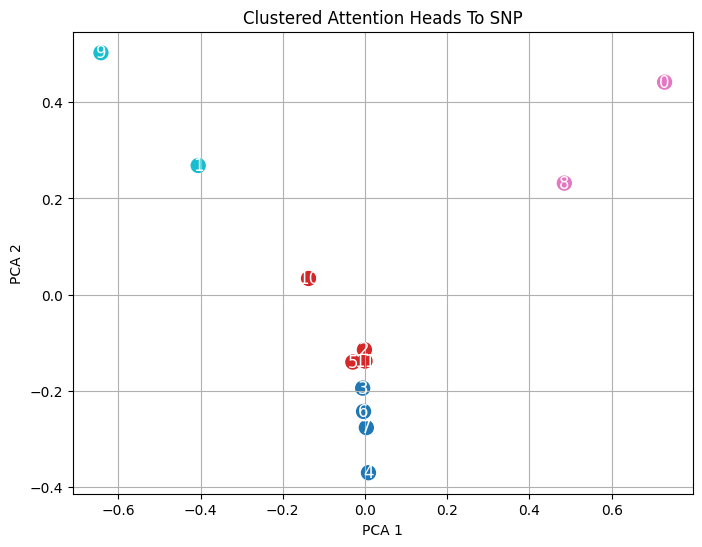

In [49]:
head_vectors = mean_to_snp[:, :max_length].cpu().numpy()
pca = PCA(n_components=2)
head_vectors_2d = pca.fit_transform(head_vectors)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(head_vectors_2d)
plt.figure(figsize=(8, 6))
plt.scatter(head_vectors_2d[:, 0], head_vectors_2d[:, 1], c=labels, cmap='tab10', s=100)
for i in range(len(labels)):
    plt.text(head_vectors_2d[i, 0], head_vectors_2d[i, 1], str(i), fontsize=12, ha='center', va='center', color='white')
plt.title("Clustered Attention Heads To SNP")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

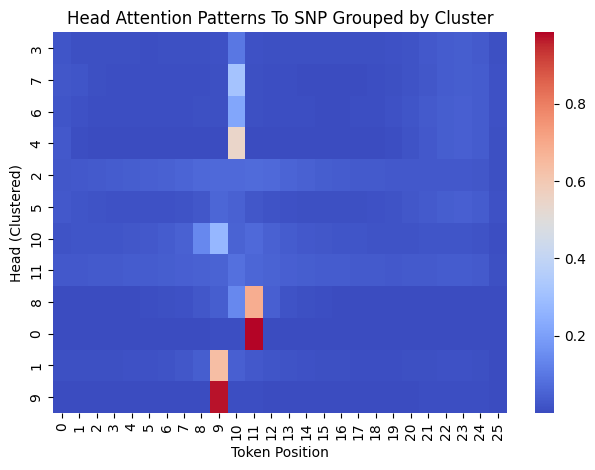

In [50]:
cluster_order = np.argsort(labels)  # sort heads by cluster
ax = sns.heatmap(mean_to_snp[cluster_order, :max_length].cpu().numpy(), cmap="coolwarm", xticklabels=True, yticklabels=cluster_order)
ax.set_title("Head Attention Patterns To SNP Grouped by Cluster")
ax.set_xlabel("Token Position")
ax.set_xticklabels([str(i) for i in range(max_length)], rotation=90)
ax.set_ylabel("Head (Clustered)")
ax.set_xticks(np.arange(max_length) + 0.5)
ax.set_xticklabels([str(i) for i in range(max_length)], rotation=90)
plt.tight_layout()
plt.show()

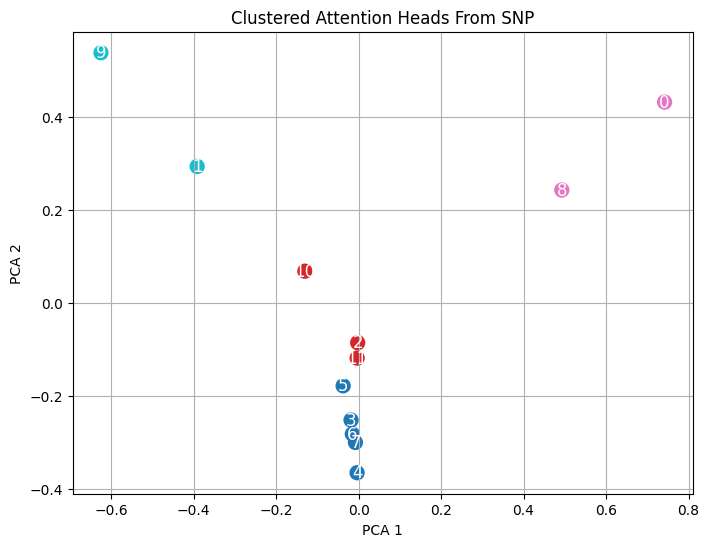

In [51]:
head_vectors = mean_from_snp[:, :max_length].cpu().numpy()
pca = PCA(n_components=2)
head_vectors_2d = pca.fit_transform(head_vectors)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(head_vectors_2d)
plt.figure(figsize=(8, 6))
plt.scatter(head_vectors_2d[:, 0], head_vectors_2d[:, 1], c=labels, cmap='tab10', s=100)
for i in range(len(labels)):
    plt.text(head_vectors_2d[i, 0], head_vectors_2d[i, 1], str(i), fontsize=12, ha='center', va='center', color='white')
plt.title("Clustered Attention Heads From SNP")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


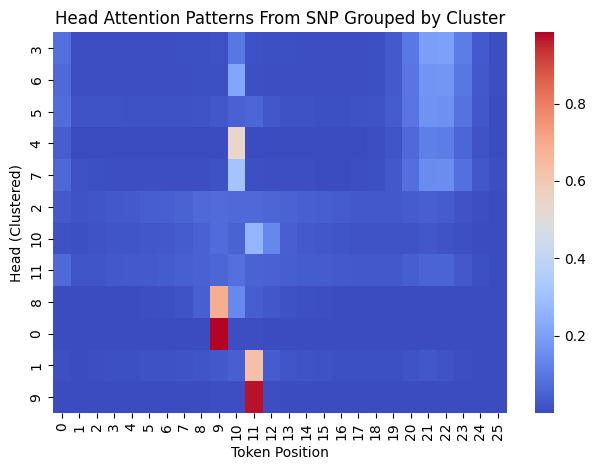

In [52]:
cluster_order = np.argsort(labels)  # sort heads by cluster
ax = sns.heatmap(mean_from_snp[cluster_order, :max_length].cpu().numpy(), cmap="coolwarm", xticklabels=True, yticklabels=cluster_order)
ax.set_title("Head Attention Patterns From SNP Grouped by Cluster")
ax.set_xlabel("Token Position")
ax.set_xticklabels([str(i) for i in range(max_length)], rotation=90)
ax.set_ylabel("Head (Clustered)")
ax.set_xticks(np.arange(max_length) + 0.5)
ax.set_xticklabels([str(i) for i in range(max_length)], rotation=90)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Head Specialization Clusters')

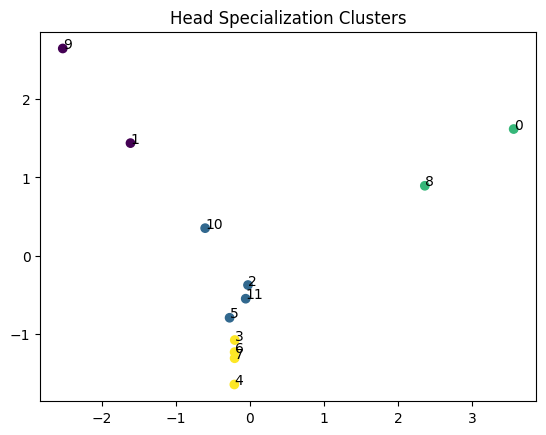

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

head_vectors = avg_attn.reshape(avg_attn.shape[0], -1).cpu().numpy()
pca = PCA(n_components=2).fit_transform(head_vectors)
kmeans = KMeans(n_clusters=4).fit(pca)

for i, txt in enumerate(range(len(pca))):
    plt.annotate(txt, (pca[i,0], pca[i,1]))

# Plot
import matplotlib.pyplot as plt
plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
plt.title("Head Specialization Clusters")

In [ ]:
def find_snp_token_idx(sequence, snp_pos=50, tokenizer=None):
    """
    Given a DNA sequence and SNP position (0-based),
    find which BPE token index covers the SNP base.

    Args:
      sequence (str): DNA sequence
      snp_pos (int): SNP base index in sequence
      tokenizer: HuggingFace tokenizer (DNABERT2)

    Returns:
      snp_token_idx (int): index of token covering SNP base
      tokens (list[str]): list of tokens for sequence
    """

    tokens = tokenizer.tokenize(sequence)
    pos = 0
    token_spans = []
    for t in tokens:
        token_str = t.replace("##", "")
        length = len(token_str)
        token_spans.append((pos, pos + length))
        pos += length

    reconstructed = "".join([t.replace("##", "") for t in tokens])
    assert reconstructed == sequence,
    # Find token covering SNP position
    for idx, (start, end) in enumerate(token_spans):
        if start <= snp_pos < end:
            return idx, tokens

    # If SNP pos not found
    return None, tokens

## Reference Attention

In [39]:
# Load sequences from your SNP alt FASTA file
fasta_path = "snps_contexts_101bp_upper.fa"
records = list(SeqIO.parse(fasta_path, "fasta"))

seq_ids = [rec.id for rec in records]
sequences = [str(rec.seq).upper() for rec in records]

batch_size = 32
refattention_results = []
save_every = 1000
processed = 0

def batch_tokenize(seqs):
    return tokenizer(seqs, return_tensors="pt", padding=True, truncation=True)

for i in range(0, len(sequences), batch_size):
    batch_seqs = sequences[i:i+batch_size]
    batch_ids = seq_ids[i:i+batch_size]

    inputs = batch_tokenize(batch_seqs)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, return_dict=True, output_attentions=True)

    attentions = outputs[3]
    last_layer_attention = attentions[-1]

    for j, seq_id in enumerate(batch_ids):
        refattention_results.append({
            "id": seq_id,
            "sequence": batch_seqs[j],
            "attention": last_layer_attention[j].cpu()
        })

    processed += len(batch_seqs)

    if processed % save_every == 0:
        torch.save(refattention_results, f'refattention_results_upto_{processed}.pt')
        print(f'Saved attention results for {processed} sequences.')

# Save final results
torch.save(refattention_results, 'refattention_results_final.pt')
print('Saved final attention results.')

Saved attention results for 4000 sequences.
Saved attention results for 8000 sequences.
Saved attention results for 12000 sequences.
Saved attention results for 16000 sequences.
Saved attention results for 20000 sequences.
Saved attention results for 24000 sequences.
Saved attention results for 28000 sequences.
Saved attention results for 32000 sequences.
Saved attention results for 36000 sequences.
Saved attention results for 40000 sequences.
Saved attention results for 44000 sequences.
Saved attention results for 48000 sequences.
Saved attention results for 52000 sequences.
Saved attention results for 56000 sequences.
Saved attention results for 60000 sequences.
Saved attention results for 64000 sequences.
Saved attention results for 68000 sequences.
Saved attention results for 72000 sequences.
Saved attention results for 76000 sequences.
Saved attention results for 80000 sequences.
Saved attention results for 84000 sequences.
Saved attention results for 88000 sequences.
Saved attent

In [43]:
refattention_results_upto_60000 = torch.load('refattention_results_upto_60000.pt')

ref_all_attn = torch.stack([pad_attention(x["attention"]) for x in refattention_results_upto_60000])

# Average over sequences
ref_avg_attn = ref_all_attn.mean(dim=0)

snp_token_index = 10

diff_attn = avg_attn - ref_avg_attn

from_diff = diff_attn[:, snp_token_index, :]
to_diff = diff_attn[:, :, snp_token_index]


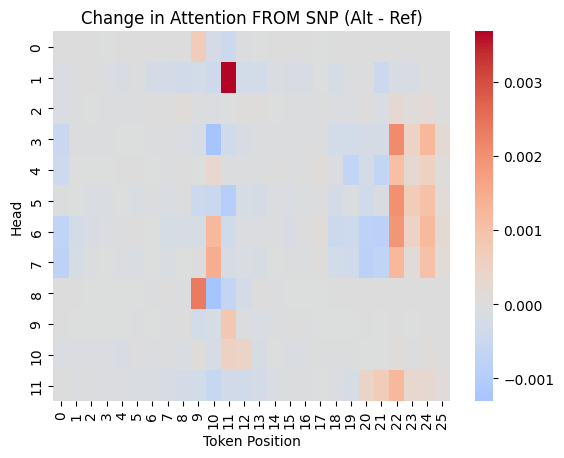

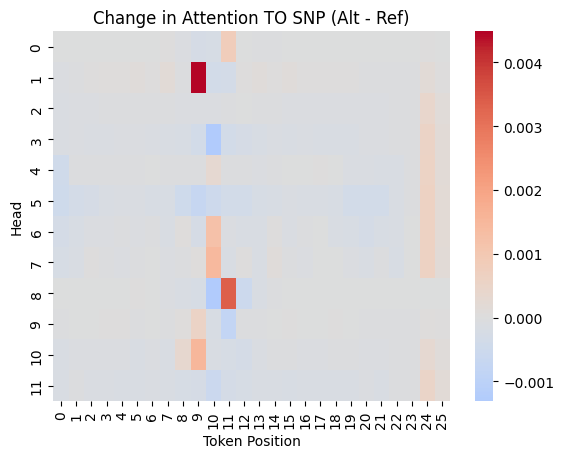

In [45]:
sns.heatmap(from_diff.cpu().numpy(), cmap="coolwarm", center=0)
plt.title("Change in Attention FROM SNP (Alt - Ref)")
plt.xlabel("Token Position")
plt.ylabel("Head")
plt.show()

sns.heatmap(to_diff.cpu().numpy(), cmap="coolwarm", center=0)
plt.title("Change in Attention TO SNP (Alt - Ref)")
plt.xlabel("Token Position")
plt.ylabel("Head")
plt.show()



In [58]:
head_mean_abs_change = torch.mean(torch.abs(from_diff), dim=1)
print(head_mean_abs_change)

tensor([5.8745e-05, 2.8796e-04, 5.6680e-05, 3.0830e-04, 1.8118e-04, 2.9393e-04,
        3.8340e-04, 3.0718e-04, 1.8160e-04, 6.3522e-05, 9.3168e-05, 2.3205e-04])


In [59]:
head_max_abs_change = torch.max(torch.abs(from_diff), dim=1).values
print(head_max_abs_change)

tensor([0.0007, 0.0037, 0.0002, 0.0021, 0.0010, 0.0020, 0.0019, 0.0014, 0.0023,
        0.0008, 0.0005, 0.0012])


In [60]:
token_mean_change = torch.mean(from_diff, dim=0)
print(token_mean_change)

tensor([-2.2941e-04, -5.9519e-05, -3.6798e-05, -4.1871e-05, -4.2690e-05,
        -3.5576e-05, -4.6471e-05, -7.4593e-05, -7.4001e-05,  1.1403e-04,
        -1.4521e-04,  1.4308e-04, -7.4813e-05, -1.0280e-04, -3.3915e-05,
        -4.9710e-05, -3.1303e-05,  2.2928e-05, -1.4249e-04, -1.6990e-04,
        -1.6759e-04, -2.0615e-04,  8.0327e-04,  1.8937e-04,  4.4878e-04,
         7.5864e-05])


In [3]:
import torch
token_mean_change = torch.tensor([-2.2941e-04, -5.9519e-05, -3.6798e-05, -4.1871e-05, -4.2690e-05,
        -3.5576e-05, -4.6471e-05, -7.4593e-05, -7.4001e-05,  1.1403e-04,
        -1.4521e-04,  1.4308e-04, -7.4813e-05, -1.0280e-04, -3.3915e-05,
        -4.9710e-05, -3.1303e-05,  2.2928e-05, -1.4249e-04, -1.6990e-04,
        -1.6759e-04, -2.0615e-04,  8.0327e-04,  1.8937e-04,  4.4878e-04,
         7.5864e-05])

token_mean_change.argsort(dim=0, descending=True)[:5]

tensor([22, 24, 23, 11,  9])

In [61]:
max_change_pos = torch.argmax(torch.abs(token_mean_change))
print(token_mean_change)

tensor([-2.2941e-04, -5.9519e-05, -3.6798e-05, -4.1871e-05, -4.2690e-05,
        -3.5576e-05, -4.6471e-05, -7.4593e-05, -7.4001e-05,  1.1403e-04,
        -1.4521e-04,  1.4308e-04, -7.4813e-05, -1.0280e-04, -3.3915e-05,
        -4.9710e-05, -3.1303e-05,  2.2928e-05, -1.4249e-04, -1.6990e-04,
        -1.6759e-04, -2.0615e-04,  8.0327e-04,  1.8937e-04,  4.4878e-04,
         7.5864e-05])
